<a href="https://colab.research.google.com/github/SYongho/MY/blob/use-keras-tuner/LH_PG_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model, load_model, model_from_yaml
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from time import strftime

In [2]:
!pip install git+https://github.com/keras-team/keras-tuner.git

  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-patx1qud
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-patx1qud
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-cp36-none-any.whl size=92439 sha256=1bc11851fb18a9d86f300c0db542b91536b370ccba030c9e1aae329b555b957a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bfzeis5h/wheels/33/f9/be/250538026c0381bfee3fe34b533f483c15dbfde8fbb61c8bbd
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=e6c012f13107a9ad99f5c9ce95404f1bed179cd41dfc8e76826f9b375902a81b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

# Data split

In [4]:
csv_inp = pd.read_csv('ins.csv')
csv_out = pd.read_csv('outs.csv')

inp_columns = csv_inp.columns
out_columns = csv_out.columns

train_inp = csv_inp[:310].values
train_out = csv_out[:310].values
test_inp = csv_inp[310:].values
test_out = csv_out[310:].values

train_inp, val_inp, train_out, val_out = train_test_split(train_inp, train_out, test_size=0.1, random_state=38)

train_inp_i = pd.DataFrame(train_inp, columns=inp_columns)
train_out_i = pd.DataFrame(train_out, columns=out_columns)
val_inp_i = pd.DataFrame(val_inp, columns=inp_columns)
val_out_i = pd.DataFrame(val_out, columns=out_columns)
test_inp_i = pd.DataFrame(test_inp, columns=inp_columns)
test_out_i = pd.DataFrame(test_out, columns=out_columns)

### Train Normalization


In [5]:
min_max_scaler = preprocessing.MinMaxScaler()

train_inp = pd.DataFrame(min_max_scaler.fit_transform(train_inp_i), columns=inp_columns)
train_out = pd.DataFrame(min_max_scaler.fit_transform(train_out_i), columns=out_columns)

### Validation Normalization

In [6]:
val_inp = pd.DataFrame(min_max_scaler.fit_transform(val_inp_i), columns=inp_columns)
val_out = pd.DataFrame(min_max_scaler.fit_transform(val_out_i), columns=out_columns)

### Test Normalization

In [7]:
test_inp = pd.DataFrame(min_max_scaler.fit_transform(test_inp_i), columns=inp_columns)
test_out = pd.DataFrame(min_max_scaler.fit_transform(test_out_i), columns=out_columns)

# Model

In [8]:
def build_model(hp):
  optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
  kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)
  kernel_initializer = tf.keras.initializers.he_normal(seed=None)
  bias_regularizer = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)

  model_inp = Input(shape=(5,))
  model = Dense(units=hp.Int('units_1', 10, 100, 5), activation='relu', 
                kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, bias_regularizer=bias_regularizer, bias_initializer='zeros', name='Dense_1')(model_inp)
  model = Dropout(hp.Float('dropout_1', 0, 0.5, 0.01))(model)
  model = BatchNormalization()(model)
  model = Dense(units=hp.Int('units_2', 10, 100, 5), activation='relu', 
                kernel_regularizer=kernel_regularizer, kernel_initializer=kernel_initializer, bias_regularizer=bias_regularizer, bias_initializer='zeros', name='Dense_2')(model)
  model = Dropout(hp.Float('dropout_2', 0, 0.5, 0.01))(model)
  model = BatchNormalization()(model)
  model = Dense(2, activation='linear', name='output')(model)

  model = Model(inputs=model_inp, outputs=model)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

  return model

In [9]:
tuner = BayesianOptimization(
    build_model, objective='mse', max_trials=20, seed=38, executions_per_trial=3)

In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 5, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 5, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': None}


In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='min')]

tuner.search(train_inp, train_out, epochs=3000, validation_data=(val_inp, val_out), callbacks=callbacks, verbose=2)
tuner.results_summary()

Trial 20 Complete [00h 02m 09s]
mse: 0.0029447325505316257

Best mse So Far: 0.0029447325505316257
Total elapsed time: 00h 41m 54s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units_1: 70
dropout_1: 0.01
units_2: 15
dropout_2: 0.02
Score: 0.0029447325505316257
Trial summary
Hyperparameters:
units_1: 80
dropout_1: 0.04
units_2: 10
dropout_2: 0.01
Score: 0.0031595524245252213
Trial summary
Hyperparameters:
units_1: 20
dropout_1: 0.01
units_2: 95
dropout_2: 0.08
Score: 0.0037648101958135762
Trial summary
Hyperparameters:
units_1: 90
dropout_1: 0.11
units_2: 95
dropout_2: 0.03
Score: 0.003995265578851104
Trial summary
Hyperparameters:
units_1: 70
dropout_1: 0.02
units_2: 45
dropout_2: 0.14
Score: 0.004092000192031264
Trial summary
Hyperparameters:
units_1: 15
dropout_1: 0.07
units_2: 15
dropout_2: 0.04
Score: 0.004385614612450202
Trial summary
Hyperparameters:

In [12]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(test_inp, test_out)

2/2 [==============================] - 0s 3ms/step - loss: 0.1442 - mse: 0.0101


[0.14423510432243347, 0.01012313924729824]

In [14]:
def RMSE(targets, predictions):
  return np.sqrt(np.mean(np.square(targets-predictions)))

def MAPE(targets, predictions):
  return np.mean(np.abs((targets-predictions) / targets)) * 100

def MSE(targets, predictions):
  return np.mean(np.square(targets-predictions))

def rescale(x_i, x):
  _max = x_i.max()
  _min = x_i.min()
  return x * (_max - _min) + _min

### Prediction

In [15]:
evaluates = best_model.evaluate(test_inp, test_out, batch_size=128, verbose=2)
test_predictions = pd.DataFrame(best_model.predict(test_inp, batch_size=128), columns=out_columns)

test_out_rescaled = rescale(test_out_i, test_out)
test_pred_rescaled = rescale(test_out_i, test_predictions)

test_output = pd.DataFrame(test_out_rescaled, columns=out_columns)
test_predict = pd.DataFrame(test_pred_rescaled, columns=out_columns)

test_out_LH = test_output[out_columns[0]]
test_pred_LH = test_predict[out_columns[0]]
test_out_PG = test_output[out_columns[1]]
test_pred_PG = test_predict[out_columns[1]]

1/1 - 0s - loss: 0.1442 - mse: 0.0101


## Error

In [16]:
def Error_Df():
  df = [evaluates[0],
        RMSE(test_out_LH, test_pred_LH), RMSE(test_out_PG, test_pred_PG),
        MAPE(test_out_LH, test_pred_LH), MAPE(test_out_PG, test_pred_PG),
        MSE(test_out_LH, test_pred_LH), MSE(test_out_PG, test_pred_PG),
        metrics.r2_score(test_out_LH, test_pred_LH), metrics.r2_score(test_out_PG, test_pred_PG)]
  error_col = ['Test loss', 'pred_LH RMSE', 'pred_PG RMSE', 'pred_LH MAPE', 'pred_PG MAPE', 'pred_LH MSE', 'pred_PG MSE', 'LH_R2 score', 'PG_R2 score']

  return pd.DataFrame([df], columns=error_col)

In [17]:
Error_Df()

,Test loss,pred_LH RMSE,pred_PG RMSE,pred_LH MAPE,pred_PG MAPE,pred_LH MSE,pred_PG MSE,LH_R2 score,PG_R2 score
0,0.144235,0.092273,461.347691,14.484149,27.26803,0.008514,212841.692286,0.614649,0.927945


## Plot

In [18]:
def plot_compare_LH(true, prediction):
  plt.scatter(true, prediction, c='k', s=1.8)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('square')
  plt.xlim([0,1])
  plt.ylim([0,1])
  _ = plt.plot([-100,100], [-100,100])

def plot_compare_PG(true, prediction):
  plt.scatter(true, prediction, c='k', s=1.8)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.axis('square')
  plt.xlim([0,max(true)-(max(true)%10)+1000])
  plt.ylim([0,max(true)-(max(true)%10)+1000])
  _ = plt.plot([-20000,20000], [-20000,20000])

,test_out_LH,test_pred_LH
0,0.33,0.347941
1,0.58,0.620653
2,0.63,0.544087
3,0.65,0.562165
4,0.62,0.560684
5,0.44,0.420441
6,0.71,0.550021
7,0.76,0.632362
8,0.59,0.484869
9,0.77,0.651025


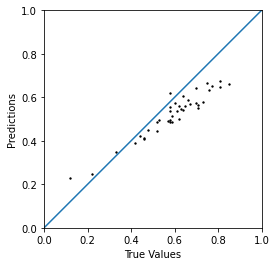

In [19]:
plot_compare_LH(test_out_LH, test_pred_LH)
pd.DataFrame({'test_out_LH':test_out_LH,
              'test_pred_LH':test_pred_LH})

,test_out_PG,test_pred_PG
0,1460.0,982.104675
1,1002.0,639.790207
2,2214.0,1377.309254
3,779.0,1093.477080
4,490.0,306.211337
5,584.0,485.213137
6,266.0,419.672985
7,2900.0,3189.635067
8,648.0,580.876155
9,1480.0,1407.819898


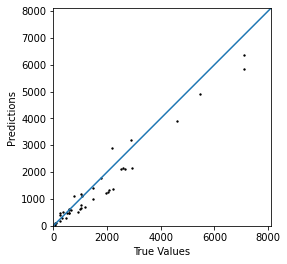

In [20]:
plot_compare_PG(test_out_PG, test_pred_PG)
pd.DataFrame({'test_out_PG':test_out_PG,
              'test_pred_PG':test_pred_PG})

## Save model

In [21]:
from keras.models import load_model

best_model.save('tuner_2layers_model.h5')

## Sensitivity Analysis

In [22]:
def sensitivity_analysis(variable, targets):
  _corr = variable.corrwith(targets)
  columns = variable.columns
  color = np.where(_corr > 0, 'r', np.where(_corr > 0, _corr, 'b'))

  plt.figure(figsize=(10, 5))
  plt.barh(columns, _corr, color=color)
  plt.xticks(np.arange(-1, 1, 0.1))
  plt.show()

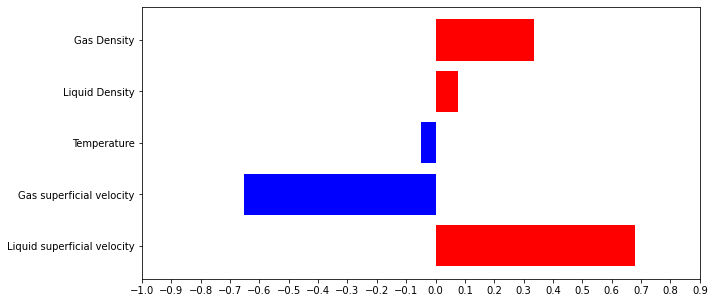

In [23]:
sensitivity_analysis(test_inp_i, test_pred_LH)

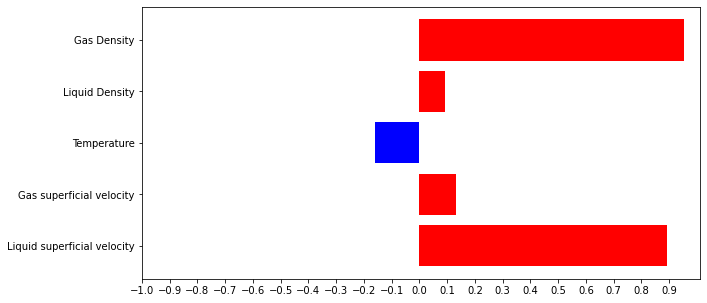

In [24]:
sensitivity_analysis(test_inp_i, test_pred_PG)

## Load model

In [ ]:
model = load_model('tuner_2layers_model.h5')